In [1]:
# Algorithmic methods imports

import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage, misc
from PIL import Image
from google.colab.patches import cv2_imshow

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import numpy as np
from IPython.display import clear_output 

In [3]:
data_path = "./drive/MyDrive/CSC413 Project/trainA"
label_path = "./drive/MyDrive/CSC413 Project/trainB"

# Defining algorithmic processing methods
Written by Kevin Zhang

In [4]:
########################################################
# PART 1 - Median Filtering
########################################################
def median_filter(image_path):
  img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE) # Load image
  img_median = cv2.medianBlur(img, 25) # Add median filter to image
  result = np.minimum(img.astype(np.uint16)+(255-img_median.astype(np.uint16)), 255)
  return result.astype(np.uint8)

In [5]:
########################################################
# PART 2 - Edge Detection, Dilation Erosion
########################################################
def edge_dilation_erosion_filter(image_path):
  img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE) # Load image
  edges = cv2.Canny(img,100,200)
  dilated = cv2.dilate(edges, np.ones((3,3),np.uint8), iterations=1)
  eroded = cv2.erode(dilated, np.ones((4,4),np.uint8), iterations=1)
  return cv2.bitwise_not(eroded)

In [6]:
########################################################
# PART 3 - Adaptive Filter
########################################################
def adaptive_filter(image_path):
  img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE) # Load image
  return cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY,15,20)

## Creating images using algorithmic methods

Written by Kevin Zhang

In [7]:
if not os.path.exists(data_path+"/median_filtered"):
  os.mkdir(data_path+"/median_filtered")
if not os.path.exists(data_path+"/edge_dilation_erosion"):
  os.mkdir(data_path+"/edge_dilation_erosion")
if not os.path.exists(data_path+"/adaptive_filtered"):
  os.mkdir(data_path+"/adaptive_filtered")

for img in sorted(os.listdir(data_path)):
  if img.endswith('.png'):
    input_image_path = os.path.join(data_path,img)

    median_filter_path = os.path.join(data_path+"/median_filtered",img)
    edge_dilation_erosion_path = os.path.join(data_path+"/edge_dilation_erosion",img)
    adaptive_filter_path = os.path.join(data_path+"/adaptive_filtered",img)

    if not os.path.exists(adaptive_filter_path):
      cv2.imwrite(median_filter_path, median_filter(input_image_path))
    if not os.path.exists(edge_dilation_erosion_path):
      cv2.imwrite(edge_dilation_erosion_path, edge_dilation_erosion_filter(input_image_path))
    if not os.path.exists(adaptive_filter_path):
      cv2.imwrite(adaptive_filter_path, adaptive_filter(input_image_path))

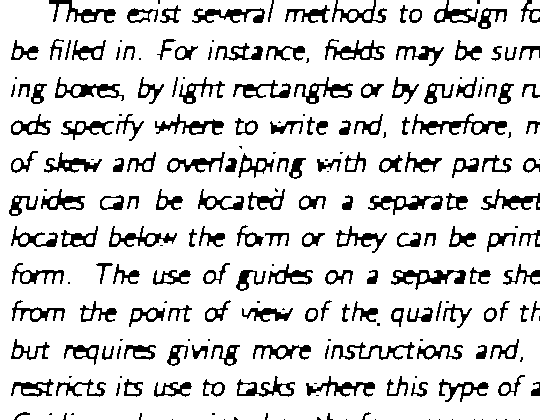

In [8]:
# Test image
result = edge_dilation_erosion_filter(os.path.join(data_path, "img_0000.png"))
cv2_imshow(result)

# Machine Learning Methods
Written by Jay Yoo

In [9]:
def prepare_params(batch_size=128, num_epochs=100, learning_rate=1e-4, \
                   summary_epoch_interval=10, loss_function=nn.MSELoss(), \
                   optimizer=torch.optim.Adam):
  # optimizer is passed the function definition, not a called function 
    # (note the lack of brackets in the base argument)
  
  params = {
      'batch_size' : batch_size,
      'num_epochs' : num_epochs,
      'learning_rate' : learning_rate,
      'summary_epoch_interval' : summary_epoch_interval, 
      'loss_function' : loss_function, 
      'optimizer' : optimizer,
  }

  return params

In [10]:
class model_container():
  def __init__(self, dataset, model, params):
    # Model does not have to be transferred to cuda gpu

    self.batch_size = params['batch_size']
    self.num_epochs = params['num_epochs']
    self.learning_rate = params['learning_rate']
    self.summary_epoch_interval = params['summary_epoch_interval']
    self.loss_function = params['loss_function']
    self.optimizer = params['optimizer']

    self.dataloader = DataLoader(dataset, batch_size=self.batch_size, pin_memory=True, num_workers=0)
    self.model = model.cuda()

  def train(self):
    self.model.train()

    # optimizer = torch.optim.Adam(lr=learning_rate, params=self.model.parameters())
    optimizer = self.optimizer(lr=self.learning_rate, params=self.model.parameters())

    for epoch in range(1, self.num_epochs + 1):
        cumulated_loss = 0

        for model_input, labels in self.dataloader:
            model_input = model_input.cuda()
            labels = labels.cuda()
            model_output = self.model(model_input)
            loss = self.loss_function(model_output, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            cumulated_loss += loss.item()
            
        if not epoch % self.summary_epoch_interval:
            print("Epoch %d, Total loss %0.6f" % (epoch, cumulated_loss))

  def inference(self, data_to_infer, dataset_shapes, save_path=None, filenames=None):
    # Assumed to be list of numpy
    # Add option to automatically save to a directory if memory is a concern

    self.model.eval()

    if save_path is None:
      outputs = []
      for data in data_to_infer:
        model_input = torch.from_numpy(data)
        model_input = model_input.type(torch.FloatTensor)
        model_input = model_input.cuda()
        outputs.append(self.model(model_input).cpu().detach().numpy())

      return outputs
    else:
      if filenames is None:
        filenames = [str(idx) for idx in range(len(data_to_infer))]
      for idx, data in enumerate(data_to_infer):
        model_input = torch.from_numpy(data)
        model_input = model_input.type(torch.FloatTensor)
        model_input = model_input.cuda()
        model_output = self.model(model_input).cpu().detach().numpy()

        cv2.imwrite(os.path.join(save_path, filenames[idx]) + '.png', model_output)

  def delete_data(self):
    # For memory optimizations
    del self.dataloader
  
  def get_model():
    self.model.eval()
    return self.model

##  Autoencoder model
Written by Jay Yoo

In [11]:
class autoencoder_dataset(Dataset):
    def __init__(self, data, labels):
        super().__init__()
        # data and labels are both (dataset size, m, n) where images are m x n

        self.num_data = len(data)
        self.train_data = torch.unsqueeze(torch.from_numpy(data), dim=1)
        self.train_data = self.train_data.type(torch.FloatTensor)
        self.labels = torch.from_numpy(labels)
        self.labels = self.labels.type(torch.FloatTensor)

    def __len__(self):
        return self.num_data

    def __getitem__(self, idx):
        return self.train_data[idx], self.labels[idx]

In [12]:
def autoencoder_layer(in_channels, out_channels, kernel_size=3, stride=1, \
                  padding=1, bias=True, batchnorm=True, activation='relu', \
                  upsample=None):
    # Convolution layer that maintains shape 
        # with optional activation layer and batchnorm
    # Use stride = 1, kernel = 3, padding = 1 for convenience
    # Activation argument is one of 'relu', 'sigmoid', 'leaky_relu', or 'none

    layers = []

    # Upsampling
    if upsample is not None:
        layers.append(nn.Upsample(scale_factor=upsample))

    # Adding convolutional layer
    layers.append(nn.Conv2d(in_channels=in_channels, \
                            out_channels=out_channels, \
                            kernel_size=kernel_size, \
                            stride=stride, \
                            padding=padding, \
                            bias=bias))

    # Adding batchnorm
    if batchnorm:
        layers.append(nn.BatchNorm2d(out_channels))

    # Adding activation
    if activation == 'relu':
        layers.append(nn.ReLU())
    elif activation == 'sigmoid':
        layers.append(nn.Sigmoid())
    elif activation == 'leaky_relu':
        layers.append(nn.LeakyReLU())
    elif activation == 'none':
        pass
    else:
        assert False, "Invalid activation function."
        
    return nn.Sequential(*layers)

class autoencoder(nn.Module):
    def __init__(self, num_hidden_channels=64):
        super().__init__()
        
        self.net = []

        self.net.append(autoencoder_layer(in_channels=1, \
                                      out_channels=num_hidden_channels, \
                                      activation='leaky_relu', \
                                      batchnorm=True, \
                                      upsample=None))
        self.net.append(autoencoder_layer(in_channels=num_hidden_channels, \
                                      out_channels=num_hidden_channels, \
                                      activation='leaky_relu', \
                                      batchnorm=False, \
                                      upsample=None))
        self.net.append(nn.MaxPool2d(2)) # Pool to half of shape
        self.net.append(autoencoder_layer(in_channels=num_hidden_channels, \
                                      out_channels=num_hidden_channels, \
                                      activation='leaky_relu', \
                                      batchnorm=True, \
                                      upsample=None))
        self.net.append(autoencoder_layer(in_channels=num_hidden_channels, \
                                      out_channels=num_hidden_channels, \
                                      activation='leaky_relu', \
                                      batchnorm=False, \
                                      upsample=2))
        self.net.append(autoencoder_layer(in_channels=num_hidden_channels, \
                                      out_channels=1, \
                                      activation='sigmoid', \
                                      batchnorm=False, \
                                      upsample=None))
        
        self.net = nn.Sequential(*self.net)
    
    def forward(self, concatenated_inputs):
        output = self.net(concatenated_inputs)
        return output.squeeze()

In [13]:
def get_images_from_dir(data_path, track_progress=True, stop_idx=None, \
                        dataset_shapes=None):

  dir_paths = os.listdir(data_path)
  num_paths = len(dir_paths)

  if stop_idx is None:
    stop_idx = num_paths

  if track_progress == True:
    def show_progress(idx):
      clear_output()
      print(idx, '/', stop_idx)
  else:
    def show_progress(idx):
      pass

  if dataset_shapes is None:
    png_idx = 0
    dataset_shapes = []
    for idx, img in enumerate(sorted(dir_paths)):
      if png_idx == stop_idx:
        break
        
      show_progress(png_idx)
      if img.endswith('.png'):
        image_path = os.path.join(data_path,img)
        raw_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        dataset_shapes.append(raw_image.shape)
        png_idx += 1

  num_pngs = len(dataset_shapes)
  image_shape = [None, None]
  for shape_idx in range(2):
    image_shape[shape_idx] = max([shape[shape_idx] for shape in dataset_shapes])
  images = np.zeros([num_pngs] + image_shape)

  png_idx = 0
  for idx, img in enumerate(sorted(dir_paths)):
    if png_idx == stop_idx:
      break

    show_progress(idx)
    if img.endswith('.png'):
      image_path = os.path.join(data_path,img)
      raw_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
      diff_y = (image_shape[0] - raw_image.shape[0]) // 2
      diff_x = (image_shape[1] - raw_image.shape[1]) // 2
      images[png_idx, \
             diff_y:image_shape[0] - diff_y, \
             diff_x:image_shape[1] - diff_x] = raw_image
      png_idx += 1

  return images, dataset_shapes

In [14]:
autoencoder_train_data, dataset_shapes = get_images_from_dir(data_path, stop_idx=500)
autoencoder_labels, dataset_shapes = get_images_from_dir(label_path, dataset_shapes=dataset_shapes, stop_idx=500)

1348 / 2448


KeyboardInterrupt: ignored

In [ ]:
dataset = autoencoder_dataset(autoencoder_train_data, autoencoder_labels)
autoencoder_model = autoencoder(num_hidden_channels=32)
autoencoder_params = prepare_params(batch_size=16, summary_epoch_interval=1, num_epochs=5, learning_rate=1e-2)

In [ ]:
del autoencoder_train_data
del autoencoder_labels

In [ ]:
autoencoder = model_container(dataset, autoencoder_model, autoencoder_params, dataset_shapes)

In [ ]:
autoencoder.train()

In [ ]:
# Just for testing code, have to change to get actual test data

autoencoder.delete_data()
autoencoder_train_data, dataset_shapes = get_images_from_dir(data_path, stop_idx=50, dataset_shapes=dataset_shapes)
autoencoder.inference()